In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

import emcee
import george
from george import kernels
import corner

import matplotlib.pyplot as plt
%matplotlib notebook

# The Neverending Search for Periodicity: Techniques Beyond Lomb-Scargle

**Version 0.1**

***
By AA Miller 28 Apr 2018

In this lecture we will examine alternative methods to search for periodic signals in astronomical time series. The problems will provide a particular focus on a relatively new technique, which is to model the periodic behavior as a Gaussian Process, and then sample the posterior to identify the optimal period via Markov Chain Monte Carlo analysis. A lot of this work has been pioneered by previous DSFP lecturer Suzanne Aigrain.

For a refresher on GPs, see Suzanne's previous lectures: [part 1](https://github.com/LSSTC-DSFP/LSSTC-DSFP-Sessions/blob/master/Session4/Day2/GPLecture1.ipynb) & [part 2](https://github.com/LSSTC-DSFP/LSSTC-DSFP-Sessions/blob/master/Session4/Day3/GPLecture2.ipynb). For a refresher on MCMC, see Andy Connolly's previous lectures: [part 1](https://github.com/LSSTC-DSFP/LSSTC-DSFP-Sessions/blob/master/Session4/Day2/LSSTC-DSFP4-Connolly-IntroductionToMCMC.ipynb), [part 2](https://github.com/LSSTC-DSFP/LSSTC-DSFP-Sessions/blob/master/Session4/Day2/LSSTC-DSFP4-Connolly-IntroductionToPYMC3.ipynb), & [part 3](https://github.com/LSSTC-DSFP/LSSTC-DSFP-Sessions/blob/master/Session4/Day2/LSSTC-DSFP4-Connolly-SamplingTechniquesInMCMC.ipynb).

## An Incomplete Whirlwind Tour

In addition to LS, the following techniques are employed to search for periodic signals:

#### String Length

The string length method ([Dworetsky 1983](http://adsabs.harvard.edu/abs/1983MNRAS.203..917D)), phase folds the data at trial periods and then minimizes the distance to connect the phase-ordered observations.

<img style="display: block; margin-left: auto; margin-right: auto" src="./images/StringLength.png" align="middle">

<div align="right"> <font size="-3">(credit: Gaveen Freer - http://slideplayer.com/slide/4212629/#) </font></div>

#### Phase Dispersion Minimization

Phase Dispersion Minimization (PDM; [Jurkevich 1971](http://adsabs.harvard.edu/abs/1971Ap%26SS..13..154J), [Stellingwerth 1978](http://adsabs.harvard.edu/abs/1978ApJ...224..953S)), like LS, folds the data at a large number of trial frequencies $f$. 

The phased data are then binned, and the variance is calculated in each bin, combined, and compared to the overall variance of the signal. No functional form of the signal is assumed, and thus, non-sinusoidal signals can be found.

*Challenge*: how to select the number of bins?

<img style="display: block; margin-left: auto; margin-right: auto" src="./images/PDM.jpg" align="middle">

<div align="right"> <font size="-3">(credit: Gaveen Freer - http://slideplayer.com/slide/4212629/#) </font></div>

#### Analysis of Variance

Analysis of Variance (AOV; [Schwarzenberg-Czerny 1989](http://adsabs.harvard.edu/abs/1989MNRAS.241..153S)) is similar to PDM. Optimal periods are defined via hypothesis testing, and these methods are found to perform best for certain types of astronomical signals.

#### Supersmoother

Supersmoother ([Reimann](http://adsabs.harvard.edu/abs/1994PhDT........20R)) is a least-squares approach wherein a flexible, non-parametric model is fit to the folded observations at many trial frequncies. The use of this flexible model reduces aliasing issues relative to models that assume a sinusoidal shape, however, this comes at the cost of requiring considerable computational time. 

#### Conditional Entropy

Conditional Entropy (CE; [Graham et al. 2013](http://adsabs.harvard.edu/abs/2013MNRAS.434.2629G)), and other entropy based methods, aim to minimize the entropy in binned (normalized magnitude, phase) space. CE, in particular, is good at supressing signal due to the window function.

When tested on real observations, CE outperforms most of the alternatives (e.g., LS, PDM, etc).

<img style="display: block; margin-left: auto; margin-right: auto" src="./images/CE.png" align="middle">

<div align="right"> <font size="-3">(credit: Graham et al. 2013) </font></div>

#### Bayesian Methods

There have been some efforts to frame the period-finding problem in a Bayesian framework. [Bretthorst 1988](https://www.springer.com/us/book/9780387968711) developed Bayesian generalized LS models, while [Gregory & Loredo 1992](http://adsabs.harvard.edu/abs/1992ApJ...398..146G) applied Bayesian techniques to phase-binned models. 

More recently, efforts to use Gaussian processes (GPs) to model and extract a period from the light curve have been developed ([Wang et al. 2012](http://adsabs.harvard.edu/abs/2012ApJ...756...67W)). These methods have proved to be especially useful for detecting stellar rotation in Kepler light curves ([Angus et al. 2018](http://adsabs.harvard.edu/abs/2018MNRAS.474.2094A)). 

[Think of Suzanne's lectures during session 4]

For this lecture we will focus on the use GPs, combined with an MCMC analysis (and we will take some shortcuts in the interest of time), to identify periodic signals in astronomical data.  

## Problem 1) Helper Functions

We are going to create a few helper functions, similar to the previous lecture, that will help minimize repetition for some common tasks in this notebook. 

**Problem 1a**

Adjust the variable `ncores` to match the number of CPUs on your machine.

In [2]:
ncores =  4        # adjust to number of CPUs on your machine
np.random.seed(23)

**Problem 1b**

Create a function `gen_periodic_data` that returns 

$$y = C + A\cos\left(\frac{2\pi x}{P}\right) + \sigma_y$$

where $C$, $A$, and $P$ are constants, $x$ is input data and $\sigma_y$ represents Gaussian noise.

*Hint* - this should only require a minor adjustment to your function from lecture 1.

In [4]:
def gen_periodic_data(x,y_unc,C,A,P):
    y = C + A*np.cos(2*np.pi*x/P) + y_unc
    return y

**Problem 1c**

Later, we will be using MCMC. Execute the following cell which will plot the chains from `emcee` to follow the MCMC walkers.

In [5]:
def plot_chains(sampler, nburn, paramsNames):
    Nparams = len(paramsNames)  # + 1
    fig, ax = plt.subplots(Nparams,1, figsize = (8,2*Nparams), sharex = True)
    fig.subplots_adjust(hspace = 0)
    ax[0].set_title('Chains')
    xplot = range(len(sampler.chain[0,:,0]))

    for i,p in enumerate(paramsNames):
        for w in range(sampler.chain.shape[0]):
            ax[i].plot(xplot[:nburn], sampler.chain[w,:nburn,i], color="0.5", alpha = 0.4, lw = 0.7, zorder = 1)
            ax[i].plot(xplot[nburn:], sampler.chain[w,nburn:,i], color="k", alpha = 0.4, lw = 0.7, zorder = 1)
            
            ax[i].set_ylabel(p)
    fig.tight_layout()
    return ax

**Problem 1d** 

Using `gen_periodic_data` generate 250 observations taken at random times between 0 and 10, with $C = 10$, $A = 2$, $P = 0.4$, and variance of the noise = 0.1. Create an uncertainty array `dy` with the same length as `y` and each value equal to $\sqrt{0.1}$.

Plot the resulting data over the exact (noise-free) signal.

<IPython.core.display.Javascript object>


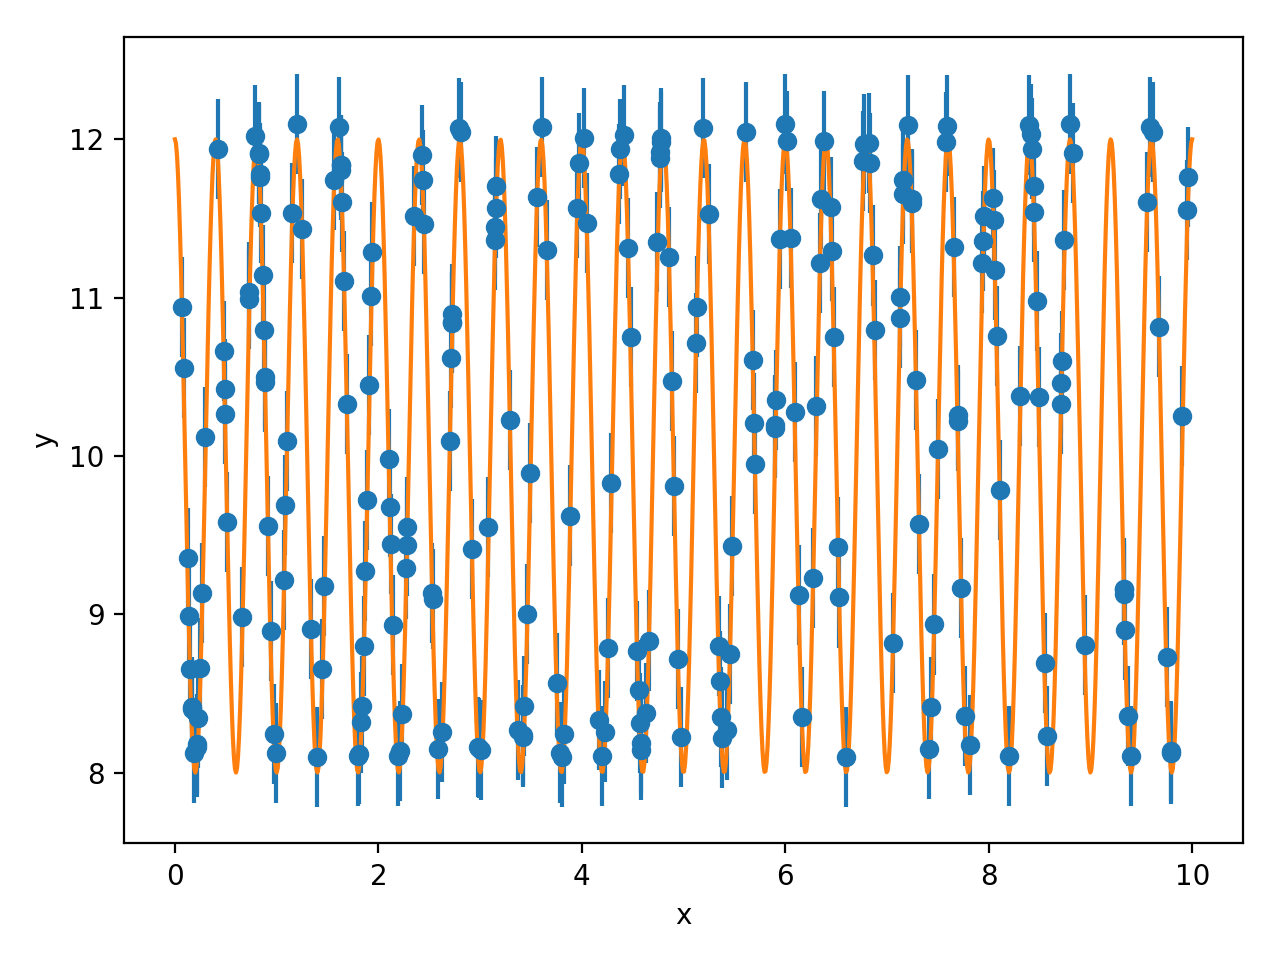

In [7]:
# genertate observations
x = np.random.rand(250)*10
y = gen_periodic_data(x,0.1,C=10,A=2,P=0.4)
dy = np.ones_like(x)*np.sqrt(0.1)

# create a grid for plotting times
x_grid=np.linspace(0,10,1000)

fig, ax = plt.subplots()
ax.errorbar(x,y,dy,fmt='o')
ax.plot(x_grid,10 + 2*np.cos(2*np.pi*x_grid/0.4))
plt.xlabel('x')
plt.ylabel('y')
fig.tight_layout()

## Problem 2) Maximum-Likelihood Optimization

A common approach$^\dagger$ in the literature for problems where there is good reason to place a strong prior on the signal (i.e. to only try and fit a single model) is maximum likelihood optimization [this is sometimes also called $\chi^2$ minimization].

$^\dagger$The fact that this approach is commonly used, does not mean it should be commonly used.

In this case, where we are fitting for a known signal in simulated data, we are justified in assuming an extremely strong prior and fitting a sinusoidal model to the data.

**Problem 2a**

Write a function, `correct_model`, that returns the expected signal for our data given input time $t$:

$$f(t) = a + b\cos\left(\frac{2\pi t}{c}\right)$$

where $a, b, c$ are model parameters.

*Hint* - store the model parameters in a single variable (this will make things easier later).

In [8]:
def correct_model(model_params,t):
    a = model_params[0]
    b = model_params[1]
    c = model_params[2]
    f = a+b*np.cos((2*np.pi*t)/c)
    return f

For these data the log likelihood of the data can be written as: 

$$\ln \mathcal{L} = -\frac{1}{2} \sum \left(\frac{y - f(t)}{\sigma_y}\right)^2$$

Ultimately, it is easier to minimize the negative log likelihood, so we will do that. 

**Problem 2b**

Write a function, `lnlike1`, that returns the log likelihood for the data given model parameters $\theta$, and $t, y, \sigma_y$.

Write a second function, `nll`, that returns the negative log likelihood.

In [23]:
def lnlike1(model_params, t, y, y_unc):
#     a = model_params[0]
#     b = model_params[1]
#     c = model_params[2]
#     f = a+b*np.cos((2*np.pi*t)/c) --- Don't need if do this:
    lnlike1 = - (1/2)* np.sum(((y-correct_model(model_params,t))/y_unc)**2)
    return lnlike1

def nll(model_params, t, y, y_unc):
    return -lnlike1(model_params, t, y, y_unc)

**Problem 2c**

Use the `minimize` function from `scipy.optimize` to determine maximum likelihood estimates for the model parameters for the data simulated in problem **1d**. What is the best fit period?

The optimization routine requires an initial guess for the model parameters, use 10 for the offset, 1 for the amplitude of variations, and 0.39 for the period.

*Hint* - as arguments, `minimize` takes the function, `nll`, the initial guess, and optional keyword `args`, which should be `(x, y, dy)` in this case.

In [24]:
initial_model_params = [10, 1, 0.39]
res = minimize(nll, initial_model_params, args=(x, y, dy)) 
# need x,y,dy in a list since they go into nll and that is one parameter input

print("The maximum likelihood estimate for the period is: {:.5f}".format(res.x[2]))
print(res.x)

The maximum likelihood estimate for the period is: 1.42049
[ 10.16076603   0.08334663   1.42049266]


**Problem 2d**

Plot the input model, the noisy data, and the maximum likelihood model.

How does the model fit look?

<IPython.core.display.Javascript object>


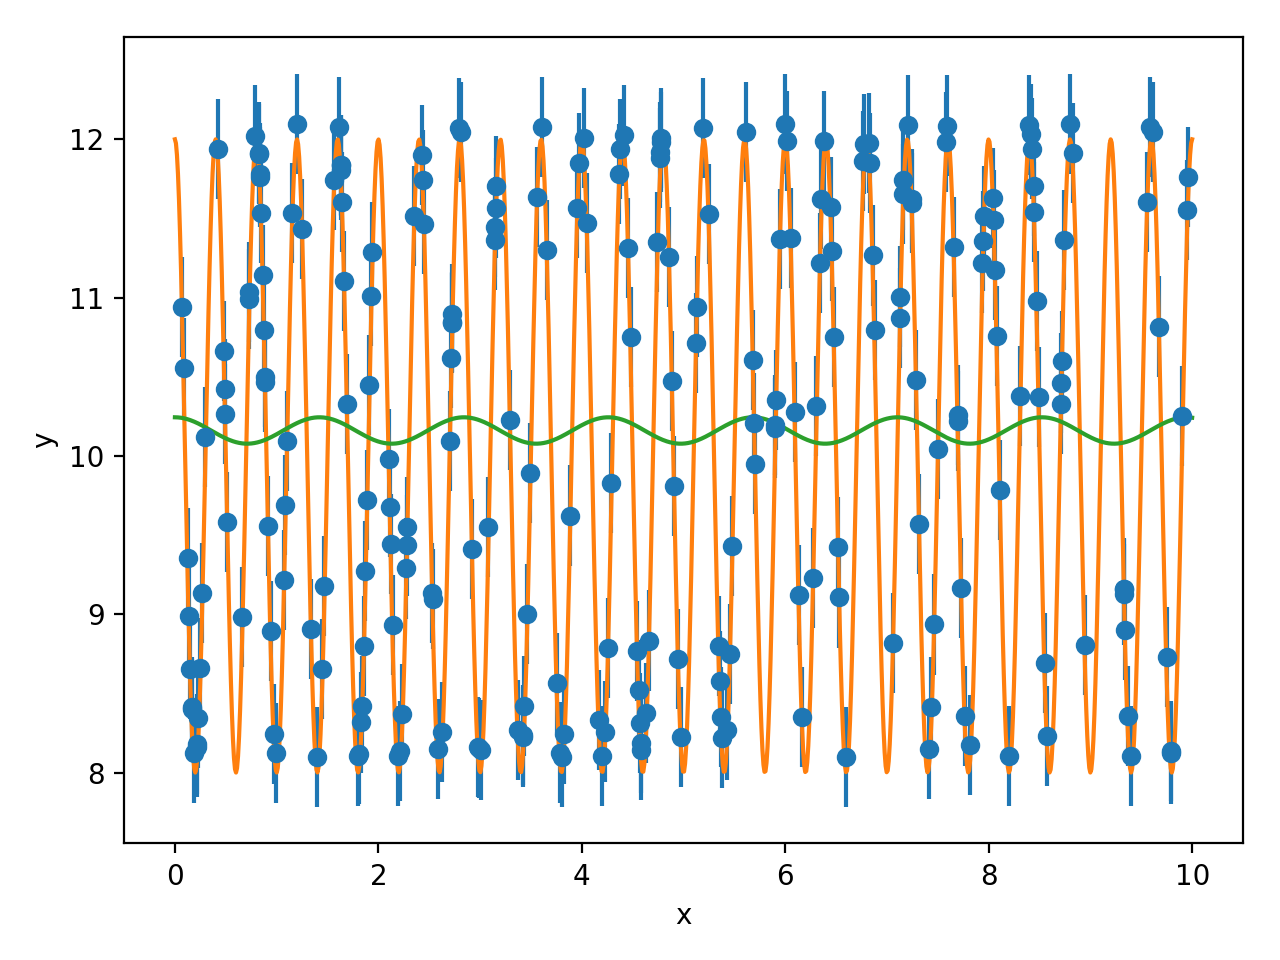

In [25]:
fig, ax = plt.subplots()
ax.errorbar(x,y,dy,fmt='o')
ax.plot(x_grid, 10 + 2*np.cos(2*np.pi*x_grid/0.4))
ax.plot(x_grid, correct_model(res.x,x_grid))
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.tight_layout()

**Problem 2e** 

Repeat the maximum likelihood optimization, but this time use an initial guess of 10 for the offset, 1 for the amplitude of variations, and 0.393 for the period.

The ML estimate for a, b, c is: 10.10000, 2.00000, 0.40000


<IPython.core.display.Javascript object>


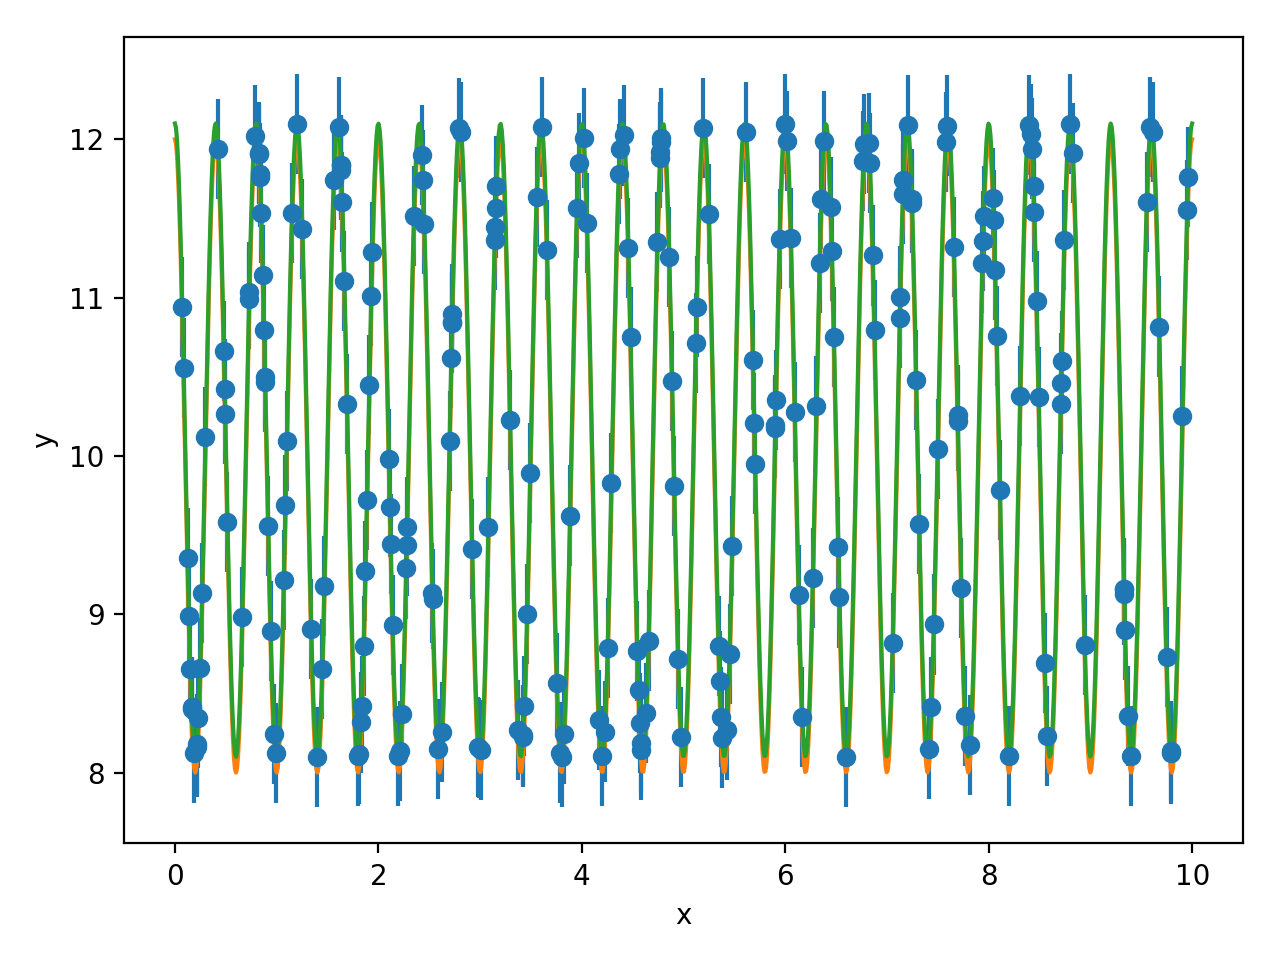

In [29]:
initial_model_params = [10, 1, 0.393]
res = minimize(nll,initial_model_params,args=(x,y,dy)) 

print("The ML estimate for a, b, c is: {:.5f}, {:.5f}, {:.5f}".format(res.x[0],res.x[1],res.x[2]))

fig, ax = plt.subplots()
ax.errorbar(x,y,dy,fmt='o')
ax.plot(x_grid, 10 + 2*np.cos(2*np.pi*x_grid/0.4))
ax.plot(x_grid, correct_model(res.x,x_grid))
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.tight_layout()

Given the lecture order this is a little late, but we have now identified the fundamental challenge in identifying periodic signals in astrophysical observations: 

**periodic models are highly non-linear**!

This can easily be seen in the LS periodograms from the previous lecture: period estimates essentially need to be perfect to properly identify the signal. Take for instance the previous example, where we adjusted the initial guess for the period by less than 1% and it made the difference between correct estimates catastrophic errors. 

This also means that classic optimization procedures (e.g., gradient decent) are helpless for this problem. If you guess the wrong period there is no obvious way to know whether the subsequent guess should use a larger or smaller period.

## Problem 3) Sampling Techniques

Given our lack of success with maximum likelihood techniques, we will now attempt a Bayesian approach. As a brief reminder, Bayes theorem tells us that:

$$P(\theta|X) \propto P(X|\theta) P(\theta).$$

In words, the posterior probability is proportional to the likelihood multiplied by the prior. We will use sampling techniques, MCMC, to estimate the posterior.

Remember - we already calculated the likelihood above.

**Problem 3a**

Write a function `lnprior1` to calculate the log of the prior on $\theta$. Use a reasonable, wide and flat prior for all the model parameters.

*Hint* - for `emcee` the log prior should return 0 within the prior and $-\infty$ otherwise.

In [31]:
def lnprior1(theta):
    a, b, c = theta
    if -20 < a < 20 and -10 < b < 10 and -5 < c < 5:
        return 0.0
    return -np.inf

**Problem 3b**

Write a function `lnprob1` to calculate the log of the posterior probability. This function should take $\theta$ and `x, y, dy` as inputs.

In [ ]:
def lnprob1(theta, x, y, dy):
    lp = lnprior1(theta)
    if np.isfinite(lp):
        return # complete
    return -np.inf

**Problem 3c**

Initialize the walkers for [`emcee`](dfm.io/emcee/current/#), which we will use to draw samples from the posterior. Like before, we need to include an initial guess (the parameters of which don't matter much beyond the period). Start with a guess of 0.6 for the period.

As a quick reminder, `emcee` is a pure python implementation of Goodman & Weare's affine Invariant Markov Chain Monte Carlo (MCMC) Ensemble sampler. `emcee` seeds several "walkers" which are members of the ensemble. You can think of each walker as its own Metropolis-Hastings chain, but the key detail is that the chains are not independent. Thus, the proposal distribution for each new step in the chain is dependent upon the position of all the other walkers in the chain. 

Choosing the initial position for each of the walkers does not significantly affect the final results (though it will affect the burn in time). Standard procedure is to create several walkers in a small ball around a reasonable guess [the samplers will quickly explore beyond the extent of the initial ball].

In [ ]:
guess = [10, 1, 0.6]
ndim = len(guess)
nwalkers = 100

p0 = [np.array(guess) + 1e-8 * np.random.randn(ndim)
      for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob1, args=(x, y, dy), threads = ncores)

**Problem 3d**

Run the walkers through 1000 steps. 

*Hint* - The `run_mcmc` method on the `sampler` object may be useful.

In [ ]:
sampler.run_mcmc(p0, 1000)

**Problem 3e**

Use the previous created `plot_chains` helper funtion to plot the chains from the MCMC sampling. Note - you may need to adjust `nburn` after examining the chains.

Have your chains converged? Will extending the chains improve this?

In [ ]:
params_names = # complete
nburn = # complete
plot_chains( # complete

**Problem 3f**

Make a corner plot (use [`corner`](https://corner.readthedocs.io/en/latest/)) to examine the post burn-in samples from the MCMC chains.

In [ ]:
samples = sampler.chain[:, nburn:, :].reshape((-1, ndim))
fig = # complete

As you can see - force feeding this problem into a Bayesian framework does not automatically generate more reasonable answers. While some of the chains appear to have identified periods close to the correct period most of them are suck in local minima. 

There are sampling techniques designed to handle multimodal posteriors, but the non-linear nature of this problem makes it difficult for the various walkers to explore the full parameter space in the way that we would like. 

## Problem 4) GPs and MCMC to identify a best-fit period

We will now attempt to model the data via a Gaussian Process (GP). As a very brief reminder, a GP is a collection of random variables, in which any finite subset has a multivariate gaussian distribution. 

A GP is fully specified by a mean function and a covariance matrix $K$. In this case, we wish to model the simulated data from problem 1. If we specify a cosine kernel for the covariance:

$$K_{ij} = k(x_i - x_j) = \cos\left(\frac{2\pi \left|x_i - x_j\right|}{P}\right)$$

then the mean function is simply the offset, `b`.

**Problem 4a**

Write a function `model2` that returns the mean function for the GP given input parameters $\theta$.

*Hint* - no significant computation is required to complete this task.

In [ ]:
def model2(theta, t):
    _, _, b= theta
    return b
# this b should be a from before

To model the GP in this problem we will use the [`george`](http://george.readthedocs.io/en/latest/) package (first introduced during session 4) written by Dan Foreman-Mackey. `george` is a fast and flexible tool for GP regression in python. It includes several built-in kernel functions, which we will take advantage of.

**Problem 4b**

Write a function `lnlike2` to calculate the likelihood for the GP model assuming a cosine kernel, and mean model defined by `model2`. 

*Note* - `george` takes $\ln P$ as an argument and not $P$. We will see why this is useful later.

*Hint* - there isn't a lot you need to do for this one! But pay attention to the functional form of the model.

In [ ]:
def lnlike2(theta, t, y, yerr):
    lnper, lna = theta[:2]
    gp = george.GP(np.exp(lna) * kernels.CosineKernel(lnper))
    gp.compute(t, yerr)
    return gp.lnlikelihood(y - model2(theta, t), quiet=True)

**Problem 4c**

Write a function `lnprior2` to calculte $\ln P(\theta)$, the log prior for the model parameters. Use a wide flat prior for the parameters.

*Note* - a flat prior in log space is not flat in the parameters.

In [ ]:
def lnprior2(theta):
    ln_period,ln_a, b = theta
    # complete
    # complete
    # complete    
    # complete
    # complete
    # complete

**Problem 4d**

Write a function `lnprob2` to calculate the log posterior given the model parameters and data.

In [ ]:
def lnprob2(# complete
    # complete
    # complete
    # complete
    # complete
    # complete
    # complete

**Problem 4e**

Intialize 100 walkers in an `emcee.EnsembleSampler` variable called `sampler`. For you initial guess at the parameter values set $\ln a = 1$, $\ln P = 1$, and $b = 8$.

*Note* - this is very similar to what you did previously.

In [ ]:
initial = # complete
ndim = len(initial)
p0 = [np.array(initial) + 1e-4 * np.random.randn(ndim)
      for i in range(nwalkers)]
sampler = emcee.EnsembleSampler( # complete

**Problem 4f**

Run the chains for 200 steps.

*Hint* - you'll notice these are shorter chains than we previously used. That is because the computational time is longer, as will be the case for this and all the remaining problems. 

In [ ]:
p0, _, _ = sampler.run_mcmc( # complete

**Problem 4g**

Plot the chains from the MCMC.

In [ ]:
params_names = ['ln(P)', 'ln(a)', 'b']
nburn = # complete
plot_chains( # complete

It should be clear that the chains have not, in this case, converged. This will be true even if you were to continue to run them for a very long time. 

Nevertheless, if we treat this entire run as a burn in, we can actually extract some useful information from this initial run. In particular, we will look at the posterior values for the different walkers at the end of their chains. From there we will re-initialize our walkers.

We are actually free to initialize the walkers at any location we choose, so this approach is not cheating. However, one thing that should make you a bit uneasy about the way in which we are re-initializing the walkers is that we have no guarantee that the initial run that we just performed found a global maximum for the posterior. Thus, it may be the case that our continued analysis in this case is not "right."

**Problem 4h**

Below you are given two arrays, `chain_lnp_end` and `chain_lnprob_end`, that contain the final $\ln P$ and log posterior, respectively, for each of the walkers.

Plot these two arrays against each other, to get a sense of what period is "best."

In [ ]:
chain_lnp_end = sampler.chain[:,-1,0]
chain_lnprob_end = sampler.lnprobability[:,-1]
fig, ax = plt.subplots()
ax.scatter( # complete
# complete
# complete
fig.tight_layout()

**Problem 4i**

Reinitialize the walkers in a ball around the maximum log posterior value from the walkers in the previous burn in. Then run the MCMC sampler for 200 steps.

*Hint* - you'll want to run `sampler.reset()` prior to the running the MCMC, but after selecting the new starting point for the walkers.

In [ ]:
p = # complete
sampler.reset()

p0 = # complete
p0, _, _ = sampler.run_mcmc( # complete

**Problem 4j**

Plot the chains. Have they converged?

In [ ]:
paramsNames = ['ln(P)', 'ln(a)', 'b']
nburn = # complete
plot_chains( # complete

**Problem 4k**

Make a corner plot of the samples. Does the marginalized distribution on $P$ make sense?

In [ ]:
fig = 

If you run the cell below, you will see random samples from the posterior overplotted on the data. Do the posterior samples seem reasonable in this case?

In [ ]:
fig, ax = plt.subplots()
ax.errorbar(x, y, dy, fmt='o')
ax.set_xlabel('x')
ax.set_ylabel('y')

for s in samples[np.random.randint(len(samples), size=5)]:
    # Set up the GP for this sample.
    lnper, lna = s[:2]
    gp = george.GP(np.exp(lna) * kernels.CosineKernel(lnper))
    gp.compute(x, dy)
    # Compute the prediction conditioned on the observations and plot it.
    m = gp.sample_conditional(y - model2(s, x), x_grid) + model2(s, x_grid)
    
    ax.plot(x_grid, m, color="0.2", alpha=0.3)
fig.tight_layout()

**Problem 4l**

What is the marginalized best period estimate, including uncertainties?

In [ ]:
# complete

print('ln(P) = {:.6f} +{:.6f} -{:.6f}'.format( # complete
print('True period = 0.4, GP Period = {:.4f}'.format( # complete

In this way - it is possible to use GPs + MCMC to determine the period in noisy irregular data. Furthermore, unlike with LS, we actually have a direct estimate on the uncertainty for that period. 

As I previously alluded to, however, the solution does depend on how we initialize the walkers. Because this is simulated data, we know that the correct period has been estimated in this case, but there's no guarantee of that once we start working with astronomical sources. This is something to keep in mind if you plan on using GPs to search for periodic signals...

## Problem 5) The Quasi-Periodic Kernel

As we saw in the first lecture, there are many sources with periodic light curves that are not strictly sinusoidal. Thus, the use of the cosine kernel (on its own) may not be sufficient to model the signal. As Suzanne told us during session, the quasi-period kernel: 

$$K_{ij} = k(x_i - x_j) = \exp \left(-\Gamma \sin^2\left[\frac{\pi}{P} \left|x_i - x_j\right|\right]\right)$$

is useful for non-sinusoidal signals. We will now use this kernel to model the variations in the simulated data.

**Problem 5a**

Write a function `lnprob3` to calculate log posterior given model parameters $\theta$ and data `x, y, dy`.

*Hint* - it may be useful to write this out as multiple functions.

In [ ]:
# complete

# complete

# complete

def lnprob3( # complete
    # complete
    # complete

**Problem 5b** 

Initialize 100 walkers around a reasonable starting point. Be sure that $\ln P = 0$ in this initialization.

Run the MCMC for 200 steps. 

*Hint* - it may be helpful to run this second step in a separate cell.

In [ ]:
# complete
# complete
# complete

sampler = emcee.EnsembleSampler( # complete

In [ ]:
p0, _, _ = sampler.run_mcmc( # complete

**Problem 5c**

Plot the chains from the MCMC. Did the chains converge?

In [ ]:
paramsNames = ['ln(P)', 'ln(a)', 'b', '$ln(\gamma)$']
nburn = # complete
plot_chains( # complete

**Problem 5d**

Plot the final $\ln P$ vs. log posterior for each of the walkers. Do you notice anything interesting?

*Hint* - recall that you are plotting the log posterior, and not the posterior.

In [ ]:
# complete
# complete
# complete
# complete
# complete
# complete

**Problem 5e**

Re-initialize the walkers around the chain with the maximum log posterior value.

Run the MCMC for 500 steps.

In [ ]:
p = # complete
sampler.reset()
# complete
sampler.run_mcmc( # complete

**Problem 5f**

Plot the chains for the MCMC. 

*Hint* - you may need to adjust the length of the burn in.

In [ ]:
paramsNames = ['ln(P)', 'ln(a)', 'b', '$ln(\gamma)$']
nburn = # complete
plot_chains( # complete

**Problem 5g**

Make a corner plot for the samples. 

Is the marginalized estimate for the period reasonable?

In [ ]:
# complete
fig = # complete

## Problem 6) GPs + MCMC for actual astronomical data

We will now apply this model to the same light curve that we studied in the LS lecture.

In this case we do not know the actual period (that's only sorta true), so we will have to be even more careful about initializing the walkers and performing burn in than we were previously.

**Problem 6a** 

Read in the data for the light curve stored in `example_asas_lc.dat`.

In [ ]:
# complete

**Problem 6b**

Adjust the prior from problem 5 to be appropriate for this data set.

In [ ]:
def lnprior3( # complete
    # complete
    # complete
    # complete
    # complete
    # complete
    # complete
    # complete

Because we have no idea where to initialize our walkers in this case, we are going to use an ad hoc common sense + brute force approach. 

**Problem 6c**

Run `LombScarge` on the data and determine the top three peaks in the periodogram. Set `nterms` = 2, and the maximum frequency to 5 (this is arbitrary but sufficient in this case).

*Hint* - you may need to search more than the top 3 periodogram values to find the 3 peaks.

In [ ]:
from astropy.stats import LombScargle

frequency, power = # complete

print('Top LS period is {}'.format(# complete
print( # complete

**Problem 6d**

Initialize one third of your 100 walkers around each of the periods identified in the previous problem (note - the total number of walkers must be an even number, so use 34 walkers around one of the top 3 frequency peaks). 

Run the MCMC for 500 steps following this initialization.

In [ ]:
initial1 = # complete
# complete
# complete

initial2 = # complete
# complete
# complete

initial3 = # complete
# complete
# complete

# complete
sampler = emcee.EnsembleSampler( # complete

In [ ]:
p0, _, _ = sampler.run_mcmc( # complete

**Problem 6e**

Plot the chains.

In [ ]:
paramsNames = ['ln(P)', 'ln(a)', 'b', '$ln(\gamma)$']
nburn =  # complete
plot_chains( # complete

**Problem 6f** 

Plot $\ln P$ vs. log posterior. 

In [ ]:
# complete
# complete
# complete
# complete
# complete
# complete

**Problem 6g**

Reinitialize the walkers around the previous walker with the maximum posterior value. 

Run the MCMC for 500 steps. Plot the chains. Have they converged?

In [ ]:
# complete
sampler.reset()
# complete
# complete
sampler.run_mcmc( # complete

In [ ]:
paramsNames = ['ln(P)', 'ln(a)', 'b', '$ln(\gamma)$']
nburn = # complete
plot_chains( # complete

**Problem 6h**

Make a corner plot of the samples. What is the marginalized estimate for the period of this source? 

How does this estimate compare to LS?

In [ ]:
# complete
fig = corner.corner( # complete

In [ ]:
# complete

print('ln(P) = {:.6f} +{:.6f} -{:.6f}'.format( # complete

print('GP Period = {:.6f}'.format( # complete

The cell below shows marginalized samples overplotted on the actual data. How well does the model perform?

In [ ]:
fig, ax = plt.subplots()
ax.errorbar(lc['hjd'], lc['mag'], lc['mag_unc'], fmt='o')
ax.set_xlabel('HJD (d)')
ax.set_ylabel('mag')

hjd_grid = np.linspace(2800, 3000,3000)

for s in samples[np.random.randint(len(samples), size=5)]:
    # Set up the GP for this sample.
    lnper, lna, b, lngamma = s
    gp = george.GP(np.exp(lna) * kernels.ExpSine2Kernel(np.exp(lngamma), lnper))
    gp.compute(lc['hjd'], lc['mag_unc'])
    # Compute the prediction conditioned on the observations and plot it.
    m = gp.sample_conditional(lc['mag'] - model3(s, lc['hjd']), hjd_grid) + model3(s, hjd_grid)
    
    ax.plot(hjd_grid, m, color="0.2", alpha=0.3)
fig.tight_layout()

Now you have the tools to fit a GP to a light and get an estimate of the best fit period (and to get an estimate of the uncertainty on that period to boot!). 

As previously noted, you should be a bit worried about "burn in" and how the walkers were initialized throughout. If you plan to use GPs to search for periods in your own work, I highly recommend you read Angus et al. 2018 on the GP periodogram. Angus et al. provide far more intelligent methods for initializing the MCMC than what is presented here.